In [1]:
import os
import sys
import numpy as np
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
%matplotlib inline
# %matplotlib notebook

from glob import glob
timer = cy.timing.Timer()
time = timer.time

sys.path.append('../../')
from greco_grb.scripts import SETTING
paths = SETTING.PATH()
print(paths)
USER = paths.USER
ICDATA_DIR = paths.ICDATA_DIR
DATA_DIR = paths.DATA_DIR
ANA_DIR = paths.ANA_DIR

from greco_grb.scripts.utils import *


#### Running at IceCube ####

LOCATION: 	 IceCube
USER: 	 cjchen
ICDATA_DIR: 	 /data/user/cjchen/csky/analyses/online_GRECO/candidate-002-p10
DATA_DIR: 	 /data/user/cjchen/2020-2021/Spring2021/greco_grb/data
ANA_DIR: 	 /data/user/cjchen/2020-2021/Spring2021/greco_grb/data/csky_output



In [2]:
class args:
    # ["GRB180423A", "GRB170527A", "GRB150716A"]
    def __init__(self, 
                 grb_name="GRB180423A", 
                 tw_in_second=10, 
                 ncpu=4, 
                 n_injs=np.round(np.r_[0:9.1:0.2], 2)):
        self.grb_name = grb_name
        self.tw_in_second = tw_in_second
        self.ncpu = ncpu
        self.n_injs = n_injs

In [3]:
ag = args(grb_name="GRB180423A")
bg_files = sorted(glob(ANA_DIR + f"/allsky_scan/with_prior_background/tw*/{ag.grb_name}_*.npz"), 
                 key=lambda x: int(x[x.find("/tw")+3:x.find(f"/{ag.grb_name}")]))

In [4]:
bgs = np.array([sparse.load_npz(bg_file).toarray()[0] for bg_file in bg_files])
bgs_sorted = np.apply_along_axis(sorted, 1, bgs)

In [5]:
pvals = []
for bg, bg_sorted in zip(bgs, bgs_sorted):
    pvals.append(np.apply_along_axis(lambda x: (bg.size - np.searchsorted(bg_sorted, x, side='left')) / bg.size, 0, bg))
pvals = np.array(pvals)
best_pvals = np.sort(pvals.min(axis=0))


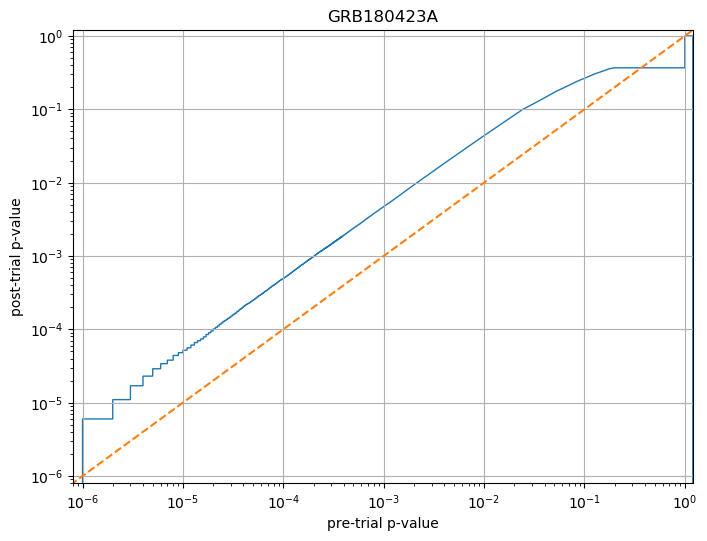

In [11]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
ax.hist(best_pvals, 
        bins=np.r_[np.unique(best_pvals),1.2], 
        normed=True, 
        cumulative=True, 
        label='CDF',
        histtype='step')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, "--")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.8e-6, 1.2)
ax.set_ylim(0.8e-6, 1.2)
ax.set_xlabel("pre-trial p-value")
ax.set_ylabel("post-trial p-value")
ax.set_title(f"{ag.grb_name}")
ax.grid()

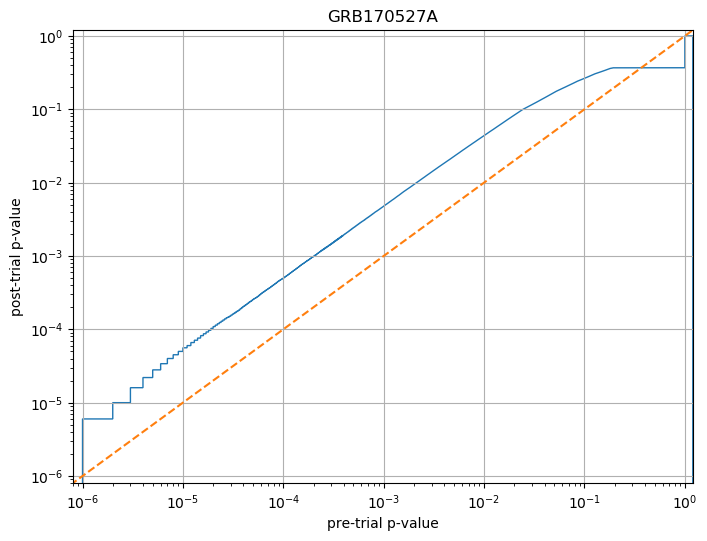

In [12]:
ag = args(grb_name="GRB170527A")
bg_files = sorted(glob(ANA_DIR + f"/allsky_scan/with_prior_background/tw*/{ag.grb_name}_*.npz"), 
                 key=lambda x: int(x[x.find("/tw")+3:x.find(f"/{ag.grb_name}")]))

bgs = np.array([sparse.load_npz(bg_file).toarray()[0] for bg_file in bg_files])
bgs_sorted = np.apply_along_axis(sorted, 1, bgs)

pvals = []
for bg, bg_sorted in zip(bgs, bgs_sorted):
    pvals.append(np.apply_along_axis(lambda x: (bg.size - np.searchsorted(bg_sorted, x, side='left')) / bg.size, 0, bg))
pvals = np.array(pvals)
best_pvals = np.sort(pvals.min(axis=0))

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
ax.hist(best_pvals, 
        bins=np.r_[np.unique(best_pvals),1.2], 
        normed=True, 
        cumulative=True, 
        label='CDF',
        histtype='step')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, "--")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.8e-6, 1.2)
ax.set_ylim(0.8e-6, 1.2)
ax.set_xlabel("pre-trial p-value")
ax.set_ylabel("post-trial p-value")
ax.set_title(f"{ag.grb_name}")
ax.grid()

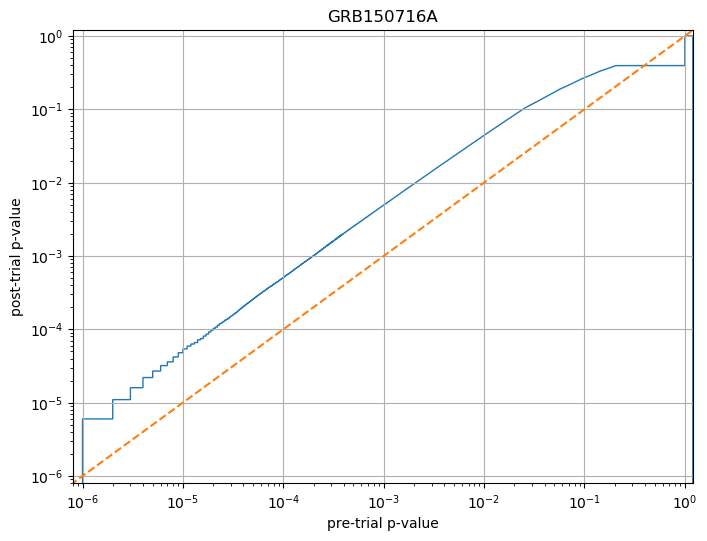

In [13]:
ag = args(grb_name="GRB150716A")
bg_files = sorted(glob(ANA_DIR + f"/allsky_scan/with_prior_background/tw*/{ag.grb_name}_*.npz"), 
                 key=lambda x: int(x[x.find("/tw")+3:x.find(f"/{ag.grb_name}")]))

bgs = np.array([sparse.load_npz(bg_file).toarray()[0] for bg_file in bg_files])
bgs_sorted = np.apply_along_axis(sorted, 1, bgs)

pvals = []
for bg, bg_sorted in zip(bgs, bgs_sorted):
    pvals.append(np.apply_along_axis(lambda x: (bg.size - np.searchsorted(bg_sorted, x, side='left')) / bg.size, 0, bg))
pvals = np.array(pvals)
best_pvals = np.sort(pvals.min(axis=0))

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
ax.hist(best_pvals, 
        bins=np.r_[np.unique(best_pvals),1.2], 
        normed=True, 
        cumulative=True, 
        label='CDF',
        histtype='step')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, "--")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.8e-6, 1.2)
ax.set_ylim(0.8e-6, 1.2)
ax.set_xlabel("pre-trial p-value")
ax.set_ylabel("post-trial p-value")
ax.set_title(f"{ag.grb_name}")
ax.grid()